In [1]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
import os

load_dotenv()
def set_env_vars(var):
    os.environ[var] = os.getenv(var)


vars = ["OPENAI_API_KEY", "LANGCHAIN_API_KEY", "LANGCHAIN_TRACING_V2", "LANGCHAIN_ENDPOINT", "LANGCHAIN_PROJECT"]

for var in vars:
    set_env_vars(var)

llm = ChatOpenAI(model="gpt-4o-mini")


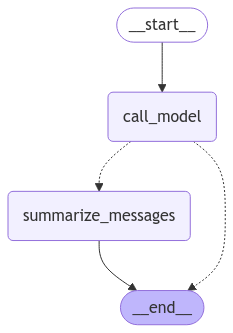

In [2]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables import RunnableConfig # to enable token wise streaming for python version < 3.11


memory = MemorySaver()


class State(MessagesState):
    summary: str


def call_model(state: State, config: RunnableConfig) -> State:

    summary = state.get("summary", "")

    if summary:
        system_message = f"Summary of the conversation earlier: {summary}"
        
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]

    result = llm.invoke(messages)
    return {"messages": result}

def summarize_messages(state: State) -> State:

    summary = state.get("summary", "")

    if summary:
        summary_message = (
            f"This is the summary of the conversation earlier: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Summarize the conversation above:"

    messages = state["messages"] + [HumanMessage(content=summary_message)] 
    result = llm.invoke(messages)

    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": result.content, "messages": delete_messages }


def should_continue(state: State) -> State:
    messages = state["messages"]

    if len(messages) > 6:
        return "summarize_messages"
    else:
        return END
    

workflow = StateGraph(State)

workflow.add_node("call_model", call_model)
workflow.add_node("summarize_messages", summarize_messages)


workflow.add_edge(START, "call_model")
workflow.add_conditional_edges("call_model", should_continue)
workflow.add_edge("summarize_messages", END)

graph = workflow.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

**.stream** = sync methods for streaming back results

**.astream** = async methods for streaming back results

**Streaming modes**

**values**  = streams full state of the graph after each node is called

**updates** = streams updates to the state of the graph after each node is called

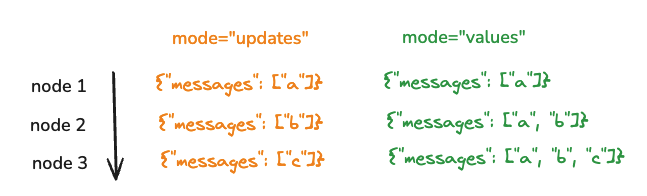

### Updates

In [5]:
config = {"configurable" : {"thread_id" : "123"}}

for chunk in graph.stream({"messages" : [HumanMessage(content="Hello, I am Hrithik!")]}, config, stream_mode="updates"):
    print(chunk)

{'call_model': {'messages': AIMessage(content='Hello again, Hrithik! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 44, 'total_tokens': 59, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'stop', 'logprobs': None}, id='run-384a90df-ed59-46ce-9002-a422eb575ed5-0', usage_metadata={'input_tokens': 44, 'output_tokens': 15, 'total_tokens': 59, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}}


In [6]:

for chunk in graph.stream({"messages" : [HumanMessage(content="Hello, I am Hrithik!")]}, config, stream_mode="updates"):
    chunk['call_model']['messages'].pretty_print()

================================== Ai Message ==================================

Hi, Hrithik! It’s nice to meet you. What would you like to talk about?


### Values

In [13]:
config = {"configurable" : {"thread_id" : "1234"}}

for event in graph.stream({"messages" : [HumanMessage(content="Hello, I am Hrithik!")]}, config,stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("-"*100)



================================ Human Message =================================

Hello, I am Hrithik!
================================== Ai Message ==================================

Hi, Hrithik! It seems like you’re excited to introduce yourself. How can I assist you today?
================================ Human Message =================================

Hello, I am Hrithik!
================================ Human Message =================================

Hello, I am Hrithik!
----------------------------------------------------------------------------------------------------
================================ Human Message =================================

Hello, I am Hrithik!
================================== Ai Message ==================================

Hi, Hrithik! It seems like you’re excited to introduce yourself. How can I assist you today?
================================ Human Message =================================

Hello, I am Hrithik!
================================ H

`.astream_events` method](https://langchain-ai.github.io/langgraph/how-tos/streaming-from-final-node/#stream-outputs-from-the-final-node), which streams back events as they happen inside nodes!

Each event is a dict with a few keys:
 
* `event`: This is the type of event that is being emitted. 
* `name`: This is the name of event.
* `data`: This is the data associated with the event.
* `metadata`: Contains`langgraph_node`, the node emitting the event.

Let's have a look.

In [20]:
config = {"configurable" : {"thread_id" : "3"}}

input_messages = [HumanMessage(content = "Tell me about the Golden State Warriors")]

async for event in graph.astream_events({"messages" : input_messages}, config, version="v2"):
    print(f'Node: {event["metadata"].get("langgraph_node")}. Type: {event["event"]}. Name: {event["name"]}')
    print("-"*100)

Node: None. Type: on_chain_start. Name: LangGraph
----------------------------------------------------------------------------------------------------
Node: __start__. Type: on_chain_start. Name: __start__
----------------------------------------------------------------------------------------------------
Node: __start__. Type: on_chain_start. Name: _write
----------------------------------------------------------------------------------------------------
Node: __start__. Type: on_chain_end. Name: _write
----------------------------------------------------------------------------------------------------
Node: __start__. Type: on_chain_start. Name: _write
----------------------------------------------------------------------------------------------------
Node: __start__. Type: on_chain_end. Name: _write
----------------------------------------------------------------------------------------------------
Node: __start__. Type: on_chain_stream. Name: __start__
-----------------------------

In [21]:
config = {"configurable" : {"thread_id" : "3"}}
node_to_stream = "call_model"

input_messages = [HumanMessage(content = "Tell me about the Golden State Warriors")]

async for event in graph.astream_events({"messages" : input_messages}, config, version="v2"):
    if event["metadata"].get("langgraph_node", "") == node_to_stream and event["event"] == "on_chat_model_stream":
        print(event["data"])
        print("-"*100)

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run-88787527-4ec5-4ea3-b294-e1fee9a05468')}
----------------------------------------------------------------------------------------------------
{'chunk': AIMessageChunk(content='The', additional_kwargs={}, response_metadata={}, id='run-88787527-4ec5-4ea3-b294-e1fee9a05468')}
----------------------------------------------------------------------------------------------------
{'chunk': AIMessageChunk(content=' Golden', additional_kwargs={}, response_metadata={}, id='run-88787527-4ec5-4ea3-b294-e1fee9a05468')}
----------------------------------------------------------------------------------------------------
{'chunk': AIMessageChunk(content=' State', additional_kwargs={}, response_metadata={}, id='run-88787527-4ec5-4ea3-b294-e1fee9a05468')}
----------------------------------------------------------------------------------------------------
{'chunk': AIMessageChunk(content=' Warriors', additional_kwargs=

In [22]:
config = {"configurable" : {"thread_id" : "4"}}
node_to_stream = "call_model"

input_messages = [HumanMessage(content = "Tell me about the Golden State Warriors")]

async for event in graph.astream_events({"messages" : input_messages}, config, version="v2"):
    if event["metadata"].get("langgraph_node", "") == node_to_stream and event["event"] == "on_chat_model_stream":
        data = event["data"]
        print(data['chunk'].content, end="|")

|The| Golden| State| Warriors| are| a| professional| basketball| team| based| in| San| Francisco|,| California|.| They| are| a| member| of| the| Western| Conference| in| the| National| Basketball| Association| (|NBA|).| Founded| in| |194|6| as| the| Philadelphia| Warriors|,| the| team| was| one| of| the| original| franchises| in| the| league|.| The| team| moved| to| California| in| |196|2| and| became| the| Golden| State| Warriors| in| |197|1|.

|###| Key| Highlights|:

|1|.| **|Champ|ionship|s|**|:| The| Warriors| have| won| multiple| NBA| championships|,| with| titles| in| |194|7|,| |195|6|,| |197|5|,| |201|5|,| |201|7|,| and| |201|8|.| Their| recent| successes| have| solid|ified| them| as| one| of| the| dominant| teams| in| modern| NBA| history|.

|2|.| **|Not|able| Players|**|:| The| team| has| featured| several| Hall| of| Fame| players|,| including| Wilt| Chamber|lain|,| Rick| Barry|,| Chris| Mull|in|,| and| more| recently|,| Stephen| Curry|,| K|lay| Thompson|,| and| Dr|ay|mond| G

# Streaming with Langgraph API

In [23]:
from langgraph_sdk import get_client

URL ="http://localhost:57313"
client = get_client(url = URL)

assistant = await client.assistants.search()

In [28]:
from pprint import pprint
pprint(assistant)

[{'assistant_id': '6f6fce9a-b777-529d-9699-dd340ddec86c',
  'config': {},
  'created_at': '2025-01-04T05:40:39.752321+00:00',
  'graph_id': 'dynamic_breakpoints',
  'metadata': {'created_by': 'system'},
  'name': 'dynamic_breakpoints',
  'updated_at': '2025-01-04T05:40:39.752321+00:00',
  'version': 1},
 {'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
  'config': {},
  'created_at': '2025-01-04T05:40:39.749151+00:00',
  'graph_id': 'agent',
  'metadata': {'created_by': 'system'},
  'name': 'agent',
  'updated_at': '2025-01-04T05:40:39.749151+00:00',
  'version': 1}]


In [29]:
thread = await client.threads.create()

input_message = HumanMessage(content = "Multiply 2 and 3")

async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id = "agent",
    input = {"messages" : [input_message]},
    stream_mode = "values"
):
    print(event)
    print("-"*100)

StreamPart(event='metadata', data={'run_id': '1efca5f6-c984-6860-91f4-2786dc66eaa0', 'attempt': 1})
----------------------------------------------------------------------------------------------------
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'a7a0898f-b477-493a-914e-aa8d356c71e4', 'example': False}]})
----------------------------------------------------------------------------------------------------
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'a7a0898f-b477-493a-914e-aa8d356c71e4', 'example': False}, {'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_CeJnEQsv6ueU6c9llvZs65pu', 'function': {'arguments

In [31]:
from langchain_core.messages import convert_to_messages

thread = await client.threads.create()

async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id = "agent",
    input = {"messages" : [input_message]},
    stream_mode = "values"
):
    messages = event.data.get("messages", None)
    if messages:
        print(convert_to_messages(messages)[-1])
    print("-"*100)

----------------------------------------------------------------------------------------------------
content='Multiply 2 and 3' additional_kwargs={'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'example': False} response_metadata={} id='9c8c8864-c50c-42bf-abaf-0a1e4e68b304'
----------------------------------------------------------------------------------------------------
content='' additional_kwargs={'additional_kwargs': {'tool_calls': [{'id': 'call_JoLVKlfsaU4FH4t9arR5jcV8', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 18, 'prompt_tokens': 134, 'total_tokens': 152, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06

### messages mode for streaming

In [33]:
thread = await client.threads.create()

input_message = HumanMessage(content = "Multiply 2 and 3")

async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id = "agent",
    input = {"messages" : [input_message]},
    stream_mode = "messages"
):
    print(event)
    print("-"*100)

StreamPart(event='metadata', data={'run_id': '1efca605-9dd7-685c-8016-e1ae41e5fc22', 'attempt': 1})
----------------------------------------------------------------------------------------------------
StreamPart(event='messages/metadata', data={'run-d82ad96c-b526-4094-8912-8af384441773': {'metadata': {'created_by': 'system', 'run_attempt': 1, 'langgraph_version': '0.2.60', 'langgraph_plan': 'developer', 'langgraph_host': 'self-hosted', 'run_id': '1efca605-9dd7-685c-8016-e1ae41e5fc22', 'user_id': '', 'graph_id': 'agent', 'thread_id': '44e9b0bd-1ef9-4bcd-90a9-05674c5d46a0', 'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca', 'langgraph_auth_user_id': '', 'langgraph_step': 1, 'langgraph_node': 'assistant', 'langgraph_triggers': ['start:assistant'], 'langgraph_path': ['__pregel_pull', 'assistant'], 'langgraph_checkpoint_ns': 'assistant:97ee4f23-af2d-33a0-84be-c7139105bf30', 'checkpoint_ns': 'assistant:97ee4f23-af2d-33a0-84be-c7139105bf30', 'ls_provider': 'openai', 'ls_model_name': 'gpt

In [34]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")

def format_tool_calls(tool_calls):
    """
    Format a list of tool calls into a readable string.

    Args:
        tool_calls (list): A list of dictionaries, each representing a tool call.
            Each dictionary should have 'id', 'name', and 'args' keys.

    Returns:
        str: A formatted string of tool calls, or "No tool calls" if the list is empty.

    """

    if tool_calls:
        formatted_calls = []
        for call in tool_calls:
            formatted_calls.append(
                f"Tool Call ID: {call['id']}, Function: {call['name']}, Arguments: {call['args']}"
            )
        return "\n".join(formatted_calls)
    return "No tool calls"

async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input={"messages": [input_message]},
    stream_mode="messages",):
    
    # Handle metadata events
    if event.event == "metadata":
        print(f"Metadata: Run ID - {event.data['run_id']}")
        print("-" * 50)
    
    # Handle partial message events
    elif event.event == "messages/partial":
        for data_item in event.data:
            # Process user messages
            if "role" in data_item and data_item["role"] == "user":
                print(f"Human: {data_item['content']}")
            else:
                # Extract relevant data from the event
                tool_calls = data_item.get("tool_calls", [])
                invalid_tool_calls = data_item.get("invalid_tool_calls", [])
                content = data_item.get("content", "")
                response_metadata = data_item.get("response_metadata", {})

                if content:
                    print(f"AI: {content}")

                if tool_calls:
                    print("Tool Calls:")
                    print(format_tool_calls(tool_calls))

                if invalid_tool_calls:
                    print("Invalid Tool Calls:")
                    print(format_tool_calls(invalid_tool_calls))

                if response_metadata:
                    finish_reason = response_metadata.get("finish_reason", "N/A")
                    print(f"Response Metadata: Finish Reason - {finish_reason}")
                    
        print("-" * 50)

Metadata: Run ID - 1efca612-13dd-6d50-94ab-d30b69fb4a5e
--------------------------------------------------
Tool Calls:
Tool Call ID: call_w1C6mD5NESlookKGjbfe0cXr, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_w1C6mD5NESlookKGjbfe0cXr, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_w1C6mD5NESlookKGjbfe0cXr, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_w1C6mD5NESlookKGjbfe0cXr, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_w1C6mD5NESlookKGjbfe0cXr, Function: multiply, Arguments: {'a': 2}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_w1C6mD5NESlookKGjbfe0cXr, Function: multiply, Arguments: {'a': 2}
--------------------------------------------------
Tool Calls:
Tool Call ID: cal